In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Activation, Conv2D, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

num_classes = 10
IMG_SIZE = 32

In [0]:
# Prepare Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

13251
[5]


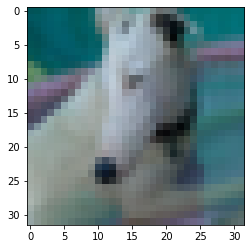

In [25]:
index = np.random.randint(x_train.shape[0])
print(index)
img, label = x_train[index], y_train[index]
print(label)
plt.imshow(img)

In [26]:
# normalization 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [0]:
# 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [42]:
# https://keras.io/applications/
# model = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=num_classes, pooling='avg')
model = keras.applications.inception_v3.InceptionV3(include_top=True, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=num_classes)

ValueError: ignored

In [39]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [0]:


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=False, 
                             save_best_only=True, 
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

logs = model.fit(x_train, y_train,
                batch_size=64,
                epochs=1000,
                verbose=1,
                callbacks=[early_stopping, reduce_lr],
                validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 71s 1ms/step - loss: 2.3188 - acc: 0.0979 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/1000
50000/50000 [==============================] - 69s 1ms/step - loss: 2.3027 - acc: 0.0969 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/1000
10112/50000 [=====>........................] - ETA: 53s - loss: 2.3026 - acc: 0.1001

KeyboardInterrupt: ignored

In [32]:
# metrics

from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = ['airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(10000,) (10000,)
              precision    recall  f1-score   support

    airplane       0.77      0.79      0.78      1000
  automobile       0.85      0.86      0.86      1000
        bird       0.65      0.63      0.64      1000
         cat       0.56      0.55      0.55      1000
        deer       0.72      0.68      0.70      1000
         dog       0.60      0.70      0.65      1000
        frog       0.79      0.82      0.80      1000
       horse       0.81      0.78      0.79      1000
        ship       0.86      0.83      0.85      1000
       truck       0.85      0.81      0.83      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000

[[787  16  53  22  15   7   7   9  58  26]
 [ 16 860   8   8   5   5   5   2  21  70]
 [ 64   7 626  62  74  67  57  28  12   3]
 [ 21   9  63 548  51 207  55  30   7   9]
 [ 18   3  75  58 681  54  57  46   6   2]
 [ 14   